In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [62]:
import numpy as np

import ujson
import attr
import random
import torch

from glob import glob
from tqdm import tqdm_notebook
from itertools import islice
from boltons.iterutils import pairwise, chunked_iter
from collections import Counter

from gensim.models import KeyedVectors
from sklearn.metrics import classification_report, accuracy_score

from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import functional as F

In [5]:
vectors = KeyedVectors.load_word2vec_format(
    '../data/vectors/GoogleNews-vectors-negative300.bin.gz',
    binary=True,
)

In [7]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)
            
    def abstract_batches(self, size):
        for chunk in chunked_iter(self.abstracts(), size):
            yield AbstractBatch(chunk)

In [8]:
@attr.s
class Abstract:
    
    sentences = attr.ib()
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
    
    def tensor(self):
        return torch.stack([s.tensor() for s in self.sentences])

In [9]:
@attr.s
class Sentence:
    
    tokens = attr.ib()
    
    def tensor(self, dim=300, pad=50):
        x = [vectors[t] for t in self.tokens if t in vectors]
        x += [np.zeros(dim)] * pad
        x = x[:pad]
        x = list(reversed(x))
        x = np.array(x)
        x = torch.from_numpy(x)
        x = x.float()
        return x

In [21]:
@attr.s
class AbstractBatch:
    
    abstracts = attr.ib()
    
    def tensor(self):
        tensors = [a.tensor() for a in self.abstracts]
        return torch.cat(tensors)
    
    def xy(self, encoded_sents):
        
        x, y = [], []
        
        start = 0
        for ab in self.abstracts:
            sents = encoded_sents[start:start+len(ab.sentences)]
            for s1, s2 in pairwise(sents):
                
                # Correct.
                x.append(torch.cat([s1, s2]))
                y.append(1)
                
                # Incorrect.
                x.append(torch.cat([s2, s1]))
                y.append(0)
                
            start += len(ab.sentences)
            
        return torch.stack(x), torch.FloatTensor(y)

In [22]:
class SentenceEncoder(nn.Module):
    
    def __init__(self, embed_dim=300, hidden_dim=128):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(embed_dim, hidden_dim, nonlinearity='relu', batch_first=True)
        
    def forward(self, x):
        hidden = Variable(torch.zeros(1, len(x), self.hidden_dim))
        _, hidden = self.rnn(x, hidden)
        return hidden

In [29]:
class Model(nn.Module):
    
    def __init__(self, input_dim=128, lin_dim=128):
        super().__init__()
        self.lin1 = nn.Linear(2*input_dim, lin_dim)
        self.out = nn.Linear(lin_dim, 1)
        
    def forward(self, x):
        y = F.relu(self.lin1(x))
        y = F.sigmoid(self.out(y))
        return y

In [67]:
train = Corpus('../data/train.json/*.json', 10000)

In [68]:
torch.manual_seed(1)
sent_encoder = SentenceEncoder()
model = Model()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
train_loss = []
for epoch in range(20):

    epoch_loss = 0
    for batch in train.abstract_batches(50):

        sent_encoder.zero_grad()
        model.zero_grad()

        sents = Variable(batch.tensor())
        sents = sent_encoder(sents)

        x, y = batch.xy(sents.squeeze())
        y = Variable(y)

        y_pred = model(x)
        y_pred = y_pred.view(-1)

        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.data[0]
        
    train_loss.append(epoch_loss)
    
    print(f'Epoch {epoch}')
    print(epoch_loss)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

Exception in thread Thread-114:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/dclure/Projects/plot-ordering/env/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/bin/../Cellar/python3/3.6.2/bin/../Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




Epoch 0
135.788811981678


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


Epoch 1
134.05175906419754


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


Epoch 2
133.10355079174042


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


Epoch 3
132.34411692619324


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


Epoch 4
131.71457707881927


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


Epoch 5
131.26094090938568


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


Epoch 6
130.85052639245987


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


Epoch 7
130.3117104768753


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


Epoch 8
129.9172244668007


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


Epoch 9
129.47825747728348


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

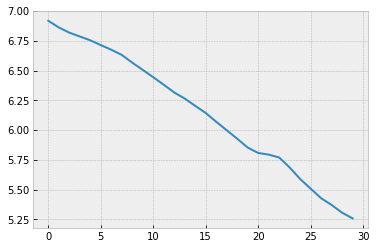

In [58]:
plt.plot(train_loss)

In [59]:
dev = Corpus('../data/dev.json/*.json', 1000)

In [60]:
yt = []
yp = []

for batch in dev.abstract_batches(30):

    sents = Variable(batch.tensor())
    sents = sent_encoder(sents)

    x, y = batch.xy(sents.squeeze())
    y = Variable(y)

    y_pred = model(x)
    y_pred = y_pred.view(-1)
    
    yt += y.data.tolist()
    yp += y_pred.round().data.tolist()

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [61]:
print(classification_report(yt, yp))

             precision    recall  f1-score   support

        0.0       0.56      0.55      0.56      4327
        1.0       0.56      0.56      0.56      4327

avg / total       0.56      0.56      0.56      8654



In [63]:
accuracy_score(yt, yp)

0.55754564363300207